In [67]:
import IPython.display as display
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from glob import glob
import pathlib
import random
import zipfile
from sklearn.model_selection import train_test_split
#from osgeo import gdal
from matplotlib import pyplot
import rasterio
import numpy as np
import tifftools
from skimage.util import view_as_blocks
from skimage.util.shape import view_as_windows
from tifffile import imsave

# Open the tif file

In [68]:
combine_hackberry = rasterio.open('7_species_tif/combine_hackberry.tif')
hackberry = combine_hackberry.read()
print(hackberry.shape)

(4, 10654, 15899)


In [69]:
#pad the array with zero so that height and width are multiples of 8
hackberry = np.pad(hackberry, ((0,0),(0,5),(0,5)), 'constant')
print(hackberry.shape)

(4, 10659, 15904)


# Check number of non-zero pixels 

In [70]:
number_of_pixels = np.where(hackberry != 0)[0].shape[0]
number_of_pixels

372772

# Use view_as_window to extract 8x8 patches

In [71]:
red = view_as_windows(hackberry[0,:,:], (8, 8),step=8)
green = view_as_windows(hackberry[1,:,:], (8, 8),step=8)
blue = view_as_windows(hackberry[2,:,:], (8, 8),step=8)
nir = view_as_windows(hackberry[3,:,:], (8, 8),step=8)
#view_as_windows(hackberry_r, (8, 8))
print('The shape of red window is:', red.shape)
print('The shape of green window is:', green.shape)
print('The shape of blue window is:', blue.shape)
print('The shape of nir window is:', nir.shape)

The shape of red window is: (1332, 1988, 8, 8)
The shape of green window is: (1332, 1988, 8, 8)
The shape of blue window is: (1332, 1988, 8, 8)
The shape of nir window is: (1332, 1988, 8, 8)


In [72]:
red_resh = np.reshape(red, red.shape[:0] + (-1,) + red.shape[2:])
green_resh = np.reshape(green, green.shape[:0] + (-1,) + green.shape[2:])
blue_resh = np.reshape(blue, blue.shape[:0] + (-1,) + blue.shape[2:])
nir_resh = np.reshape(nir, nir.shape[:0] + (-1,) + nir.shape[2:])

#Check shape after reshape
print('The shape of red reshape window is:', red_resh.shape)
print('The shape of green reshape window is:', green_resh.shape)
print('The shape of blue reshape window is:', blue_resh.shape)
print('The shape of nir reshape window is:', nir_resh.shape)

The shape of red reshape window is: (2648016, 8, 8)
The shape of green reshape window is: (2648016, 8, 8)
The shape of blue reshape window is: (2648016, 8, 8)
The shape of nir reshape window is: (2648016, 8, 8)


In [6]:
#delete all zero 8x8 windows
#red_nz = red_resh[np.all(red_resh != 0, axis=(1, 2))]
#green_nz = green_resh[np.all(green_resh != 0, axis=(1, 2))]
#blue_nz = blue_resh[np.all(blue_resh != 0, axis=(1, 2))]
#nir_nz = nir_resh[np.all(nir_resh != 0, axis=(1, 2))]

#Check shape after deleting zeros
#print('The shape of red window is:', red_nz.shape)
#print('The shape of green window is:', green_nz.shape)
#print('The shape of blue window is:', blue_nz.shape)
#print('The shape of nir window is:', nir_nz.shape)

In [7]:
#example of 8x8 window
#print(red_nz[0])
#print(red_nz[146])
#print(red_nz[526])

### This method removes any zeros in the array, but we want to keep non-zeros that are >20 pixels of the array

In [73]:
#want non-zeros to be greater than 20
red_20z = red_resh[np.count_nonzero(red_resh,axis=(1, 2)) >= 20]
green_20z = green_resh[np.count_nonzero(green_resh,axis=(1, 2)) >= 20]
blue_20z = blue_resh[np.count_nonzero(blue_resh,axis=(1, 2)) >= 20]
nir_20z = nir_resh[np.count_nonzero(nir_resh,axis=(1, 2)) >= 20]

#Check shape after threshold
print('The shape of red window is:', red_20z.shape)
print('The shape of green window is:', green_20z.shape)
print('The shape of blue window is:', blue_20z.shape)
print('The shape of nir window is:', nir_20z.shape)

The shape of red window is: (1858, 8, 8)
The shape of green window is: (1858, 8, 8)
The shape of blue window is: (1858, 8, 8)
The shape of nir window is: (1858, 8, 8)


In [75]:
#example of 8x8 window
print(red_20z[607])
print(green_20z[235])
print(blue_20z[537])

[[ 0.  0.  0.  0. 46. 43. 41. 40.]
 [ 0.  0.  0.  0. 43. 40. 42. 44.]
 [ 0.  0.  0.  0. 46. 43. 45. 46.]
 [ 0.  0.  0.  0.  0. 45. 48. 42.]
 [ 0.  0.  0.  0.  0. 45. 46. 48.]
 [ 0.  0.  0.  0. 45. 48. 49. 43.]
 [ 0.  0.  0.  0.  0. 51. 50. 45.]
 [ 0.  0.  0.  0. 55. 58. 53. 44.]]
[[86. 86. 82. 89. 81. 81. 77. 74.]
 [68. 74. 82. 91. 87. 83.  0.  0.]
 [55. 70. 88. 96. 88. 75. 68.  0.]
 [60.  0.  0. 91. 89. 81. 78. 75.]
 [76. 69.  0.  0.  0. 83. 83. 85.]
 [ 0.  0.  0.  0.  0. 91. 87. 85.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[68. 71. 68. 66. 64. 64.  0.  0.]
 [67. 68.  0.  0. 63. 64.  0.  0.]
 [65. 63. 63.  0.  0.  0.  0.  0.]
 [64. 63. 62. 64. 63.  0.  0.  0.]
 [67. 67. 63. 61. 61. 62. 62.  0.]
 [68. 68. 63. 61. 60.  0. 61. 62.]
 [67. 65. 63. 60. 59. 59. 59. 60.]
 [64. 63. 62. 60. 59. 59. 59. 59.]]


# Put RGBN together

In [76]:
hackberry_stack = np.stack([red_20z, green_20z, blue_20z, nir_20z])
print(hackberry_stack.shape)

(4, 1858, 8, 8)


In [77]:
result=[]
for i in range(hackberry_stack.shape[1]):
    stack_4 = np.stack([red_20z[i], green_20z[i], blue_20z[i], nir_20z[i]])
    result.append(stack_4)
    
hackberry_window = np.stack(result)
print('The shape of hackberry window is:', hackberry_window.shape)

The shape of hackberry window is: (1858, 4, 8, 8)


In [78]:
hackberry_window[0]

array([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  49.,  42.,  49.,   0.],
        [  0.,   0.,   0.,  59.,  41.,  41.,  51.,  48.],
        [  0.,   0.,  73.,  64.,  42.,  44.,  48.,  42.],
        [  0.,  41.,   0.,   0.,  39.,  45.,  43.,  36.],
        [  0.,  39.,  37.,  38.,  38.,  41.,  41.,  42.],
        [ 38.,  41.,  41.,  42.,  44.,  41.,  41.,  48.]],

       [[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  52.,  50.,  61.,   0.],
        [  0.,   0.,   0.,  61.,  46.,  49.,  65.,  63.],
        [  0.,   0.,  81.,  62.,  48.,  50.,  59.,  54.],
        [  0.,  49.,   0.,   0.,  43.,  52.,  52.,  45.],
        [  0.,  45.,  45.,  43.,  44.,  50.,  51.,  53.],
        [ 46.,  47.,  46.,  46.,  50.,  48.,  49.,  56.]],

       [[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 

In [141]:
#imsave('test.tif', hackberry_window[0,:,:,:])

In [142]:
#imsave('test.tif', hackberry_window[:,:,:,:])

In [31]:
for i in range(hackberry_window.shape[0]):
    name = 'hackberry/hackberry_' + str(i) + '.tif'
    imsave(name, hackberry_window[i,:,:,:])

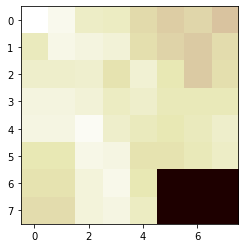

In [32]:
pyplot.imshow(rasterio.open('hackberry/hackberry_89.tif').read(1), cmap='pink')

In [33]:
rasterio.open('hackberry/hackberry_89.tif').count

4

# Use view_as_windows with 4 bands

In [79]:
hack_wind = view_as_windows(hackberry, (4, 8, 8), step=8)
print(hack_wind.shape)

(1, 1332, 1988, 4, 8, 8)


In [35]:
#Combine axes
hack_wind_resh = hack_wind.reshape(-1, 4, 8, 8)
print(hack_wind_resh.shape)

(2648016, 4, 8, 8)


In [65]:
#threshold the windows (nonzero >= 20)
num_samples = hack_wind_resh.shape[0]
hack_wind_20z = hack_wind_resh[[any([np.count_nonzero(patch) >= 20 for patch in hack_wind_resh[i]]) for i in range(0, num_samples)]]
print('The shape of hackberry window after threshold of zero is:', hack_wind_20z.shape)

The shape of hackberry window after threshold of zero is: (1858, 4, 8, 8)


In [66]:
#example of hackberry window
print(hack_wind_20z[0])

[[[  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.  49.  42.  49.   0.]
  [  0.   0.   0.  59.  41.  41.  51.  48.]
  [  0.   0.  73.  64.  42.  44.  48.  42.]
  [  0.  41.   0.   0.  39.  45.  43.  36.]
  [  0.  39.  37.  38.  38.  41.  41.  42.]
  [ 38.  41.  41.  42.  44.  41.  41.  48.]]

 [[  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.  52.  50.  61.   0.]
  [  0.   0.   0.  61.  46.  49.  65.  63.]
  [  0.   0.  81.  62.  48.  50.  59.  54.]
  [  0.  49.   0.   0.  43.  52.  52.  45.]
  [  0.  45.  45.  43.  44.  50.  51.  53.]
  [ 46.  47.  46.  46.  50.  48.  49.  56.]]

 [[  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.  64.  61.  63.   0.]
  [  0.   0.   0.  68.  61.  60.  63.  62.]
  [  0.   0.  76.  69.  61.  60.  64.  61.]
  [  0.  61.   0.   0.  60.  61.  60.  58.]
  [  0.  60.  61.  60.  60. 